
##Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)

assert os.path.isdir('./omniglot_resized')

Unzipping...Done.


In [3]:
""" Utility functions. """
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf

## Loss utilities
def cross_entropy_loss(pred, label, k_shot):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf.stop_gradient(label)) / k_shot)

def accuracy(labels, predictions):
  return tf.reduce_mean(tf.cast(tf.equal(labels, predictions), dtype=tf.float32))
    

In [4]:
"""Convolutional layers used by MAML model."""
## NOTE: You do not need to modify this block but you will need to use it.
seed = 123
def conv_block(inp, cweight, bweight, bn, activation=tf.nn.relu, residual=False):
  """ Perform, conv, batch norm, nonlinearity, and max pool """
  stride, no_stride = [1,2,2,1], [1,1,1,1]

  conv_output = tf.nn.conv2d(input=inp, filters=cweight, strides=no_stride, padding='SAME') + bweight
  normed = bn(conv_output)
  normed = activation(normed)
  return normed

class ConvLayers(tf.keras.layers.Layer):
  def __init__(self, channels, dim_hidden, dim_output, img_size):
    super(ConvLayers, self).__init__()
    self.channels = channels
    self.dim_hidden = dim_hidden
    self.dim_output = dim_output
    self.img_size = img_size

    weights = {}

    dtype = tf.float32
    weight_initializer =  tf.keras.initializers.GlorotUniform()
    k = 3

    weights['conv1'] = tf.Variable(weight_initializer(shape=[k, k, self.channels, self.dim_hidden]), name='conv1', dtype=dtype)
    weights['b1'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b1')
    self.bn1 = tf.keras.layers.BatchNormalization(name='bn1')
    weights['conv2'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv2', dtype=dtype)
    weights['b2'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b2')
    self.bn2 = tf.keras.layers.BatchNormalization(name='bn2')
    weights['conv3'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv3', dtype=dtype)
    weights['b3'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b3')
    self.bn3 = tf.keras.layers.BatchNormalization(name='bn3')
    weights['conv4'] = tf.Variable(weight_initializer([k, k, self.dim_hidden, self.dim_hidden]), name='conv4', dtype=dtype)
    weights['b4'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b4')
    self.bn4 = tf.keras.layers.BatchNormalization(name='bn4')
    weights['w5'] = tf.Variable(weight_initializer(shape=[self.dim_hidden, self.dim_output]), name='w5', dtype=dtype)
    weights['b5'] = tf.Variable(tf.zeros([self.dim_output]), name='b5')
    self.conv_weights = weights

  def call(self, inp, weights):
    channels = self.channels
    inp = tf.reshape(inp, [-1, self.img_size, self.img_size, channels])
    hidden1 = conv_block(inp, weights['conv1'], weights['b1'], self.bn1)
    hidden2 = conv_block(hidden1, weights['conv2'], weights['b2'], self.bn2)
    hidden3 = conv_block(hidden2, weights['conv3'], weights['b3'], self.bn3)
    hidden4 = conv_block(hidden3, weights['conv4'], weights['b4'], self.bn4)
    hidden4 = tf.reduce_mean(input_tensor=hidden4, axis=[1, 2])
    return tf.matmul(hidden4, weights['w5']) + weights['b5']

In [5]:
"""Data loading scripts"""
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc
import imageio

def get_images(paths, labels, n_samples=None, shuffle=True):
  """
  Takes a set of character folders and labels and returns paths to image files
  paired with labels.
  Args:
    paths: A list of character folders
    labels: List or numpy array of same length as paths
    n_samples: Number of images to retrieve per character
  Returns:
    List of (label, image_path) tuples
  """
  if n_samples is not None:
    sampler = lambda x: random.sample(x, n_samples)
  else:
    sampler = lambda x: x
  images_labels = [(i, os.path.join(path, image))
           for i, path in zip(labels, paths)
           for image in sampler(os.listdir(path))]
  if shuffle:
    random.shuffle(images_labels)
  return images_labels


def image_file_to_array(filename, dim_input):
  """
  Takes an image path and returns numpy array
  Args:
    filename: Image filename
    dim_input: Flattened shape of image
  Returns:
    1 channel image
  """
  image = imageio.imread(filename)
  image = image.reshape([dim_input])
  image = image.astype(np.float32) / 255.0
  image = 1.0 - image
  return image


class DataGenerator(object):
  """
  Data Generator capable of generating batches of Omniglot data.
  A "class" is considered a class of omniglot digits.
  """

  def __init__(self, num_classes, num_samples_per_class, num_meta_test_classes, num_meta_test_samples_per_class, config={}):
    """
    Args:
      num_classes: Number of classes for classification (K-way)
      num_samples_per_class: num samples to generate per class in one batch
      num_meta_test_classes: Number of classes for classification (K-way) at meta-test time
      num_meta_test_samples_per_class: num samples to generate per class in one batch at meta-test time
      batch_size: size of meta batch size (e.g. number of functions)
    """
    self.num_samples_per_class = num_samples_per_class
    self.num_classes = num_classes
    self.num_meta_test_samples_per_class = num_meta_test_samples_per_class
    self.num_meta_test_classes = num_meta_test_classes

    data_folder = config.get('data_folder', './omniglot_resized')
    self.img_size = config.get('img_size', (28, 28))

    self.dim_input = np.prod(self.img_size)
    self.dim_output = self.num_classes

    character_folders = [os.path.join(data_folder, family, character)
               for family in os.listdir(data_folder)
               if os.path.isdir(os.path.join(data_folder, family))
               for character in os.listdir(os.path.join(data_folder, family))
               if os.path.isdir(os.path.join(data_folder, family, character))]

    random.seed(123)
    random.shuffle(character_folders)
    num_val = 100
    num_train = 1100
    self.metatrain_character_folders = character_folders[: num_train]
    self.metaval_character_folders = character_folders[
      num_train:num_train + num_val]
    self.metatest_character_folders = character_folders[
      num_train + num_val:]

  def sample_batch(self, batch_type, batch_size, shuffle=True, swap=False):
    """
    Samples a batch for training, validation, or testing
    Args:
      batch_type: meta_train/meta_val/meta_test
      shuffle: randomly shuffle classes or not
      swap: swap number of classes (N) and number of samples per class (K) or not
    Returns:
      A a tuple of (1) Image batch and (2) Label batch where
      image batch has shape [B, N, K, 784] and label batch has shape [B, N, K, N] if swap is False
      where B is batch size, K is number of samples per class, N is number of classes
    """
    if batch_type == "meta_train":
      folders = self.metatrain_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
    elif batch_type == "meta_val":
      folders = self.metaval_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
    else:
      folders = self.metatest_character_folders
      num_classes = self.num_meta_test_classes
      num_samples_per_class = self.num_meta_test_samples_per_class
    all_image_batches, all_label_batches = [], []
    for i in range(batch_size):
      sampled_character_folders = random.sample(
        folders, num_classes)
      labels_and_images = get_images(sampled_character_folders, range(
        num_classes), n_samples=num_samples_per_class, shuffle=False)
      labels = [li[0] for li in labels_and_images]
      images = [image_file_to_array(
        li[1], self.dim_input) for li in labels_and_images]
      images = np.stack(images)
      labels = np.array(labels).astype(np.int32)
      labels = np.reshape(
        labels, (num_classes, num_samples_per_class))
      labels = np.eye(num_classes, dtype=np.float32)[labels]
      images = np.reshape(
        images, (num_classes, num_samples_per_class, -1))

      batch = np.concatenate([labels, images], 2)
      if shuffle:
        for p in range(num_samples_per_class):
          np.random.shuffle(batch[:, p])

      labels = batch[:, :, :num_classes]
      images = batch[:, :, num_classes:]

      if swap:
        labels = np.swapaxes(labels, 0, 1)
        images = np.swapaxes(images, 0, 1)

      all_image_batches.append(images)
      all_label_batches.append(labels)
    all_image_batches = np.stack(all_image_batches)
    all_label_batches = np.stack(all_label_batches)
    return all_image_batches, all_label_batches

In [6]:
"""MAML model code"""
import numpy as np
import sys
import tensorflow as tf
from functools import partial


class MAML(tf.keras.Model):
  def __init__(self, dim_input=1, dim_output=1,
               num_inner_updates=1,
               inner_update_lr=0.4, num_filters=32, k_shot=5, learn_inner_update_lr=False):
    super(MAML, self).__init__()
    self.dim_input = dim_input
    self.dim_output = dim_output
    self.inner_update_lr = inner_update_lr
    self.loss_func = partial(cross_entropy_loss, k_shot=k_shot)
    self.dim_hidden = num_filters
    self.channels = 1
    self.img_size = int(np.sqrt(self.dim_input/self.channels))

    # outputs_ts[i] and losses_ts_post[i] are the output and loss after i+1 inner gradient updates
    losses_tr_pre, outputs_tr, losses_ts_post, outputs_ts = [], [], [], []
    accuracies_tr_pre, accuracies_ts = [], []

    # for each loop in the inner training loop
    outputs_ts = [[]]*num_inner_updates
    losses_ts_post = [[]]*num_inner_updates
    accuracies_ts = [[]]*num_inner_updates

    # Define the weights - these should NOT be directly modified by the
    # inner training loop
    tf.random.set_seed(seed)
    self.conv_layers = ConvLayers(self.channels, self.dim_hidden, self.dim_output, self.img_size)

    self.learn_inner_update_lr = learn_inner_update_lr
    if self.learn_inner_update_lr:
      self.inner_update_lr_dict = {}
      for key in self.conv_layers.conv_weights.keys():
        self.inner_update_lr_dict[key] = [tf.Variable(self.inner_update_lr, name='inner_update_lr_%s_%d' % (key, j)) for j in range(num_inner_updates)]
  

  def call(self, inp, meta_batch_size=25, num_inner_updates=1):
    def task_inner_loop(inp, reuse=True,
                      meta_batch_size=25, num_inner_updates=1):
      """
        Perform gradient descent for one task in the meta-batch (i.e. inner-loop).
        Args:
          inp: a tuple (input_tr, input_ts, label_tr, label_ts), where input_tr and label_tr are the inputs and
            labels used for calculating inner loop gradients and input_ts and label_ts are the inputs and
            labels used for evaluating the model after inner updates.
            Should be shapes:
              input_tr: [N*K, 784]
              input_ts: [N*K, 784]
              label_tr: [N*K, N]
              label_ts: [N*K, N]
        Returns:
          task_output: a list of outputs, losses and accuracies at each inner update
      """
      # the inner and outer loop data
      input_tr, input_ts, label_tr, label_ts = inp

      # weights corresponds to the initial weights in MAML (i.e. the meta-parameters)
      weights = self.conv_layers.conv_weights

      # the predicted outputs, loss values, and accuracy for the pre-update model (with the initial weights)
      # evaluated on the inner loop training data
      task_output_tr_pre, task_loss_tr_pre, task_accuracy_tr_pre = None, None, None

      # lists to keep track of outputs, losses, and accuracies of test data for each inner_update
      # where task_outputs_ts[i], task_losses_ts[i], task_accuracies_ts[i] are the output, loss, and accuracy
      # after i+1 inner gradient updates
      task_outputs_ts, task_losses_ts, task_accuracies_ts = [], [], []
  
      #############################
      #### YOUR CODE GOES HERE ####
      # perform num_inner_updates to get modified weights
      # modified weights should be used to evaluate performance
      # Note that at each inner update, always use input_tr and label_tr for calculating gradients
      # and use input_ts and labels for evaluating performance

      # HINTS: You will need to use tf.GradientTape().
      # Read through the tf.GradientTape() documentation to see how 'persistent' should be set.
      # Here is some documentation that may be useful: 
      # https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients
      # https://www.tensorflow.org/api_docs/python/tf/GradientTape

      # Initial train output, before any update
      # They made weights an argument so we can forward with any set of weights
      task_output_tr_pre = self.conv_layers(input_tr, weights) 

      task_loss_tr_pre = self.loss_func(task_output_tr_pre, label_tr)
      debug = True
      weights_over_iters = []
      weights_over_iters.append(weights)
      # Update loop based on tr
      for update_i in range(num_inner_updates):
        # Compute the task-specific loss and gradient
        with tf.GradientTape(persistent=True) as inner_tape:
          task_output_tr = self.conv_layers(input_tr, weights_over_iters[update_i])
          task_loss_tr = self.loss_func(task_output_tr, label_tr)
          grad_tr = inner_tape.gradient(task_loss_tr, weights_over_iters[update_i])
        # Update copy of weights
        #for (k, w), (_, g) in zip(weights_over_iters[update_i].items(), grad_tr.items()):
        #print(k)
        #print(w.shape)
        #print(g)
        #print((w - self.inner_update_lr*g).shape)
        if self.learn_inner_update_lr:
          weights_over_iters.append({k: (w - self.inner_update_lr_dict[k]*g) for (k, w), (_, g) in zip(weights_over_iters[update_i].items(), grad_tr.items())})
        else:
          weights_over_iters.append({k: (w - self.inner_update_lr*g) for (k, w), (_, g) in zip(weights_over_iters[update_i].items(), grad_tr.items())})
        # Evaluate based on ts
        task_output_ts = self.conv_layers(input_ts, weights_over_iters[update_i+1])
        task_outputs_ts.append(task_output_ts)
        task_loss_ts = self.loss_func(task_output_ts, label_ts)
        task_losses_ts.append(task_loss_ts)
      #############################

      # Compute accuracies from output predictions
      task_accuracy_tr_pre = accuracy(tf.argmax(input=label_tr, axis=1), tf.argmax(input=tf.nn.softmax(task_output_tr_pre), axis=1))

      for j in range(num_inner_updates):
        task_accuracies_ts.append(accuracy(tf.argmax(input=label_ts, axis=1), tf.argmax(input=tf.nn.softmax(task_outputs_ts[j]), axis=1)))

      task_output = [task_output_tr_pre, task_outputs_ts, task_loss_tr_pre, task_losses_ts, task_accuracy_tr_pre, task_accuracies_ts]

      return task_output

    input_tr, input_ts, label_tr, label_ts = inp
    # to initialize the batch norm vars, might want to combine this, and not run idx 0 twice.
    unused = task_inner_loop((input_tr[0], input_ts[0], label_tr[0], label_ts[0]),
                          False,
                          meta_batch_size,
                          num_inner_updates)
    out_dtype = [tf.float32, [tf.float32]*num_inner_updates, tf.float32, [tf.float32]*num_inner_updates]
    out_dtype.extend([tf.float32, [tf.float32]*num_inner_updates])
    task_inner_loop_partial = partial(task_inner_loop, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    result = tf.map_fn(task_inner_loop_partial,
                    elems=(input_tr, input_ts, label_tr, label_ts),
                    dtype=out_dtype,
                    parallel_iterations=meta_batch_size)
    return result
   

In [7]:
"""Model training code"""
"""
Usage Instructions:
  5-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=25 --k_shot=1 --inner_update_lr=0.4 --num_inner_updates=1 --logdir=logs/omniglot5way/
  20-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=16 --k_shot=1 --n_way=20 --inner_update_lr=0.1 --num_inner_updates=5 --logdir=logs/omniglot20way/
  To run evaluation, use the '--meta_train=False' flag and the '--meta_test_set=True' flag to use the meta-test set.
"""
import csv
import numpy as np
import pickle
import random
import tensorflow as tf

def outer_train_step(inp, model, optim, meta_batch_size=25, num_inner_updates=1):
  with tf.GradientTape(persistent=False) as outer_tape:
    result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

    total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

  gradients = outer_tape.gradient(total_losses_ts[-1], model.trainable_variables)
  optim.apply_gradients(zip(gradients, model.trainable_variables))

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts

def outer_eval_step(inp, model, meta_batch_size=25, num_inner_updates=1):
  result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

  outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts  


def meta_train_fn(model, exp_string, data_generator,
               n_way=5, meta_train_iterations=15000, meta_batch_size=25,
               log=True, logdir='/tmp/data', k_shot=1, num_inner_updates=1, meta_lr=0.001):
  SUMMARY_INTERVAL = 10
  SAVE_INTERVAL = 100
  PRINT_INTERVAL = 10  
  TEST_PRINT_INTERVAL = PRINT_INTERVAL*5

  pre_accuracies, post_accuracies = [], []

  num_classes = data_generator.num_classes

  optimizer = tf.keras.optimizers.Adam(learning_rate=meta_lr)

  val_accuracies = []

  for itr in range(meta_train_iterations):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of training data and partition into
    # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
    # NOTE: The code assumes that the support and query sets have the same number of examples.
    batched_input, batched_label = data_generator.sample_batch('meta_train', batch_size=meta_batch_size, shuffle=True, swap=True)
    split_input = np.split(batched_input, 2, axis=1) # [B, K, N, 784]
    input_tr, input_ts = split_input[0], split_input[1]
    split_label = np.split(batched_label, 2, axis=1) # [B, K, N, N]
    label_tr, label_ts = split_label[0], split_label[1]
    input_tr = input_tr.reshape([meta_batch_size, -1, 784])
    input_ts = input_ts.reshape([meta_batch_size, -1, 784])
    label_tr = label_tr.reshape([meta_batch_size, -1, num_classes])
    label_ts = label_ts.reshape([meta_batch_size, -1, num_classes])
    #############################

    inp = (input_tr, input_ts, label_tr, label_ts)
    
    result = outer_train_step(inp, model, optimizer, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    if itr % SUMMARY_INTERVAL == 0:
      pre_accuracies.append(result[-2])
      post_accuracies.append(result[-1][-1])

    if (itr!=0) and itr % PRINT_INTERVAL == 0:
      print_str = 'Iteration %d: pre-inner-loop train accuracy: %.5f, post-inner-loop test accuracy: %.5f' % (itr, np.mean(pre_accuracies), np.mean(post_accuracies))
      print(print_str)
      pre_accuracies, post_accuracies = [], []

    if (itr!=0) and itr % TEST_PRINT_INTERVAL == 0:
      #############################
      #### YOUR CODE GOES HERE ####
      
      # sample a batch of validation data and partition it into
      # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
      # NOTE: The code assumes that the support and query sets have the same number of examples.
      batched_input, batched_label = data_generator.sample_batch('meta_validation', batch_size=meta_batch_size, shuffle=True, swap=True)
      split_input = np.split(batched_input, 2, axis=1) # [B, K, N, 784]
      input_tr, input_ts = split_input[0], split_input[1]
      split_label = np.split(batched_label, 2, axis=1) # [B, K, N, N]
      label_tr, label_ts = split_label[0], split_label[1]
      input_tr = input_tr.reshape([meta_batch_size, -1, 784])
      input_ts = input_ts.reshape([meta_batch_size, -1, 784])
      label_tr = label_tr.reshape([meta_batch_size, -1, num_classes])
      label_ts = label_ts.reshape([meta_batch_size, -1, num_classes])
      #############################

      inp = (input_tr, input_ts, label_tr, label_ts)
      result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
      val_accuracies.append(result[-1][-1])
      print('Meta-validation pre-inner-loop train accuracy: %.5f, meta-validation post-inner-loop test accuracy: %.5f' % (result[-2], result[-1][-1]))

  model_file = logdir + '/' + exp_string +  '/model' + str(itr)
  print("Saving to ", model_file)
  model.save_weights(model_file)

  return val_accuracies

# calculated for omniglot
NUM_META_TEST_POINTS = 600

def meta_test_fn(model, data_generator, n_way=5, meta_batch_size=25, k_shot=1,
              num_inner_updates=1):
  
  num_classes = data_generator.num_classes

  np.random.seed(1)
  random.seed(1)

  meta_test_accuracies = []

  for _ in range(NUM_META_TEST_POINTS):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of test data and partition it into
    # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
    # NOTE: The code assumes that the support and query sets have the same number of examples.
    batched_input, batched_label = data_generator.sample_batch('meta_test', batch_size=meta_batch_size, shuffle=True, swap=True)
    split_input = np.split(batched_input, 2, axis=1) # [B, K, N, 784]
    input_tr, input_ts = split_input[0], split_input[1]
    split_label = np.split(batched_label, 2, axis=1) # [B, K, N, N]
    label_tr, label_ts = split_label[0], split_label[1]
    input_tr = input_tr.reshape([meta_batch_size, -1, 784])
    input_ts = input_ts.reshape([meta_batch_size, -1, 784])
    label_tr = label_tr.reshape([meta_batch_size, -1, num_classes])
    label_ts = label_ts.reshape([meta_batch_size, -1, num_classes])
    #############################
    inp = (input_tr, input_ts, label_tr, label_ts)
    result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    meta_test_accuracies.append(result[-1][-1])

  meta_test_accuracies = np.array(meta_test_accuracies)
  means = np.mean(meta_test_accuracies)
  stds = np.std(meta_test_accuracies)
  ci95 = 1.96*stds/np.sqrt(NUM_META_TEST_POINTS)

  print('Mean meta-test accuracy/loss, stddev, and confidence intervals')
  print((means, stds, ci95))
  return meta_test_accuracies

def run_maml(n_way=5, k_shot=1, meta_batch_size=25, meta_lr=0.001,
             inner_update_lr=0.4, num_filters=32, num_inner_updates=1,
             learn_inner_update_lr=False,
             resume=False, resume_itr=0, log=True, logdir='/tmp/data',
             data_path='./omniglot_resized',meta_train=True,
             meta_train_iterations=15000, meta_train_k_shot=-1,
             meta_train_inner_update_lr=-1, model_file=None):


  # call data_generator and get data with k_shot*2 samples per class
  data_generator = DataGenerator(n_way, k_shot*2, n_way, k_shot*2, config={'data_folder': data_path})

  # set up MAML model
  dim_output = data_generator.dim_output
  dim_input = data_generator.dim_input
  model = MAML(dim_input,
              dim_output,
              num_inner_updates=num_inner_updates,
              inner_update_lr=inner_update_lr,
              k_shot=k_shot,
              num_filters=num_filters,
              learn_inner_update_lr=learn_inner_update_lr)

  if meta_train_k_shot == -1:
    meta_train_k_shot = k_shot
  if meta_train_inner_update_lr == -1:
    meta_train_inner_update_lr = inner_update_lr

  exp_string = 'cls_'+str(n_way)+'.mbs_'+str(meta_batch_size) + '.k_shot_' + str(meta_train_k_shot) + '.inner_numstep_' + str(num_inner_updates) + '.inner_updatelr_' + str(meta_train_inner_update_lr) + '.learn_inner_update_lr_' + str(learn_inner_update_lr)


  if meta_train:
    accuracies = meta_train_fn(model, exp_string, data_generator,
                  n_way, meta_train_iterations, meta_batch_size, log, logdir,
                  k_shot, num_inner_updates, meta_lr)
  else:
    meta_batch_size = 1

    #model_file = tf.train.latest_checkpoint(logdir + '/' + exp_string)
    print("Restoring model weights from ", model_file)
    model_file = tf.train.latest_checkpoint(model_file)
    model.load_weights(model_file)

    accuracies = meta_test_fn(model, data_generator, n_way, meta_batch_size, k_shot, num_inner_updates)
  
  return accuracies
  

# Prob 1.3

In [ ]:
fixed_lr = 0.04
val_acc = run_maml(n_way=5, k_shot=1, inner_update_lr=fixed_lr, num_inner_updates=1, meta_train_iterations=2000, meta_train=True, logdir='/content/gdrive/My Drive/cs330_hw2')
val_acc = np.array([v.numpy() for v in val_acc])
np.save('/content/gdrive/My Drive/cs330_hw2/val_acc_lr={:s}.npy'.format(str(fixed_lr)), val_acc)

In [ ]:
fixed_lr = 0.4
val_acc = run_maml(n_way=5, k_shot=1, inner_update_lr=fixed_lr, num_inner_updates=1, meta_train_iterations=2000, meta_train=True, logdir='/content/gdrive/My Drive/cs330_hw2')
val_acc = np.array([v.numpy() for v in val_acc])
np.save('/content/gdrive/My Drive/cs330_hw2/val_acc_lr={:s}.npy'.format(str(fixed_lr)), val_acc)

In [ ]:
fixed_lr = 4.0
val_acc = run_maml(n_way=5, k_shot=1, inner_update_lr=fixed_lr, num_inner_updates=1, meta_train_iterations=2000, meta_train=True, logdir='/content/gdrive/My Drive/cs330_hw2')
val_acc = np.array([v.numpy() for v in val_acc])
np.save('/content/gdrive/My Drive/cs330_hw2/val_acc_lr={:s}.npy'.format(str(fixed_lr)), val_acc)

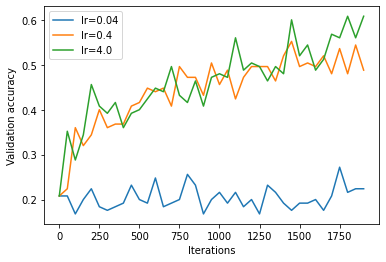

In [14]:
import matplotlib.pyplot as plt

plt.close('all')
val_acc_dict = {}
colors_dict = dict(zip(['0.04', '0.4', '4.0'], ['tab:blue', 'tab:orange', 'tab:green']))
for l in ['0.04', '0.4', '4.0']:
  val_acc_dict[l] = np.load('/content/gdrive/My Drive/cs330_hw2/val_acc_lr={:s}.npy'.format(l))
  plt.plot(np.arange(len(val_acc_dict[l]))*50, val_acc_dict[l], label='lr={:s}'.format(l), color=colors_dict[l])
plt.ylabel('Validation accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('/content/gdrive/My Drive/cs330_hw2/prob_1.3.png')

In [20]:
for l in ['0.04', '0.4', '4.0']:
  test_acc = run_maml(n_way=5, k_shot=1, inner_update_lr=float(l), num_inner_updates=1, meta_train=False, 
                      model_file='/content/gdrive/My Drive/cs330_hw2/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_{:s}.learn_inner_update_lr_False'.format(l))

Restoring model weights from  /content/gdrive/My Drive/cs330_hw2/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.04.learn_inner_update_lr_False
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.21300001, 0.136251, 0.0109023508175549)
Restoring model weights from  /content/gdrive/My Drive/cs330_hw2/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.51633334, 0.17701192, 0.014163903651598767)
Restoring model weights from  /content/gdrive/My Drive/cs330_hw2/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_4.0.learn_inner_update_lr_False
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.5686667, 0.17875, 0.014302978331771304)


# Prob 1.4

In [30]:
fixed_lr = 0.04
val_acc = run_maml(n_way=5, k_shot=1, inner_update_lr=fixed_lr, num_inner_updates=1, meta_train_iterations=2000, meta_train=True, learn_inner_update_lr=True,
                   logdir='/content/gdrive/My Drive/cs330_hw2')
val_acc = np.array([v.numpy() for v in val_acc])
np.save('/content/gdrive/My Drive/cs330_hw2/learn_lr_val_acc_lr={:s}.npy'.format(str(fixed_lr)), val_acc)

Iteration 10: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.20400
Iteration 20: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.24000
Iteration 30: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.20000
Iteration 40: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.18400
Iteration 50: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.18400
Meta-validation pre-inner-loop train accuracy: 0.19200, meta-validation post-inner-loop test accuracy: 0.20000
Iteration 60: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.24000
Iteration 70: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20000
Iteration 80: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.18400
Iteration 90: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.15200
Iteration 100: pre-inner-loop train accuracy: 0.2000

In [32]:
fixed_lr = 0.4
val_acc = run_maml(n_way=5, k_shot=1, inner_update_lr=fixed_lr, num_inner_updates=1, meta_train_iterations=2000, meta_train=True, learn_inner_update_lr=True,
                   logdir='/content/gdrive/My Drive/cs330_hw2')
val_acc = np.array([v.numpy() for v in val_acc])
np.save('/content/gdrive/My Drive/cs330_hw2/learn_lr_val_acc_lr={:s}.npy'.format(str(fixed_lr)), val_acc)

Iteration 10: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.20000
Iteration 20: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.21600
Iteration 30: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20000
Iteration 40: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20000
Iteration 50: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.21600
Meta-validation pre-inner-loop train accuracy: 0.22400, meta-validation post-inner-loop test accuracy: 0.20000
Iteration 60: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20800
Iteration 70: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.22400
Iteration 80: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.20800
Iteration 90: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.21600
Iteration 100: pre-inner-loop train accuracy: 0.1600

In [34]:
fixed_lr = 4.0
val_acc = run_maml(n_way=5, k_shot=1, inner_update_lr=fixed_lr, num_inner_updates=1, meta_train_iterations=2000, meta_train=True, learn_inner_update_lr=True,
                   logdir='/content/gdrive/My Drive/cs330_hw2')
val_acc = np.array([v.numpy() for v in val_acc])
np.save('/content/gdrive/My Drive/cs330_hw2/learn_lr_val_acc_lr={:s}.npy'.format(str(fixed_lr)), val_acc)

Iteration 10: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20400
Iteration 20: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.20000
Iteration 30: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.20800
Iteration 40: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.20000
Iteration 50: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20000
Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.19200
Iteration 60: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.20800
Iteration 70: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.25600
Iteration 80: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.24000
Iteration 90: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.26400
Iteration 100: pre-inner-loop train accuracy: 0.2240

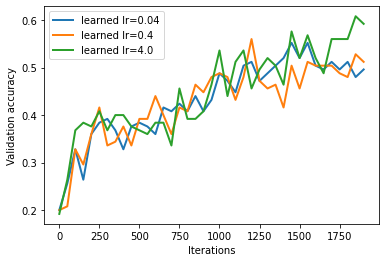

In [39]:
plt.close('all')

val_acc_dict = {}
learn_lr_val_acc_dict = {}
colors_dict = dict(zip(['0.04', '0.4', '4.0'], ['tab:blue', 'tab:orange', 'tab:green']))
for l in ['0.04', '0.4', '4.0']:
  #val_acc_dict[l] = np.load('/content/gdrive/My Drive/cs330_hw2/val_acc_lr={:s}.npy'.format(l))
  learn_lr_val_acc_dict[l] = np.load('/content/gdrive/My Drive/cs330_hw2/learn_lr_val_acc_lr={:s}.npy'.format(l))
  #plt.plot(np.arange(len(val_acc_dict[l]))*50, val_acc_dict[l], label='lr={:s}'.format(l), color=colors_dict[l])
  plt.plot(np.arange(len(learn_lr_val_acc_dict[l]))*50, learn_lr_val_acc_dict[l], label='learned lr={:s}'.format(l), linewidth=2, linestyle='solid', color=colors_dict[l])
plt.ylabel('Validation accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('/content/gdrive/My Drive/cs330_hw2/prob_1.4.png')

In [40]:
for l in ['0.04', '0.4', '4.0']:
  test_acc = run_maml(n_way=5, k_shot=1, inner_update_lr=float(l), num_inner_updates=1, meta_train=False, learn_inner_update_lr=True,
                      model_file='/content/gdrive/My Drive/cs330_hw2/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_{:s}.learn_inner_update_lr_True'.format(l))

Restoring model weights from  /content/gdrive/My Drive/cs330_hw2/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.04.learn_inner_update_lr_True
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.5133333, 0.1683911, 0.01347409371487948)
Restoring model weights from  /content/gdrive/My Drive/cs330_hw2/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_True
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.542, 0.17842646, 0.014277090219152081)
Restoring model weights from  /content/gdrive/My Drive/cs330_hw2/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_4.0.learn_inner_update_lr_True
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.57299995, 0.18404077, 0.014726328621489239)


In [31]:
#from google.colab import drive
#drive.mount('/content/drive')

In [43]:
# models/ProtoNet
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

class ProtoNet(tf.keras.Model):

  def __init__(self, num_filters, latent_dim):
    super(ProtoNet, self).__init__()
    self.num_filters = num_filters
    self.latent_dim = latent_dim
    num_filter_list = self.num_filters + [latent_dim]
    self.convs = []
    for i, num_filter in enumerate(num_filter_list):
      block_parts = [
        layers.Conv2D(
          filters=num_filter,
          kernel_size=3,
          padding='SAME',
          activation='linear'),
      ]

      block_parts += [layers.BatchNormalization()]
      block_parts += [layers.Activation('relu')]
      block_parts += [layers.MaxPool2D()]
      block = tf.keras.Sequential(block_parts, name='conv_block_%d' % i)
      self.__setattr__("conv%d" % i, block)
      self.convs.append(block)
    self.flatten = tf.keras.layers.Flatten()

  def call(self, inp):
    out = inp
    for conv in self.convs:
      out = conv(out)
    out = self.flatten(out)
    return out

def ProtoLoss(x_latent, q_latent, labels_onehot, num_classes, num_support, num_queries):
  """
    calculates the prototype network loss using the latent representation of x
    and the latent representation of the query set
    Args:
      x_latent: latent representation of supports with shape [N*S, D], where D is the latent dimension
      q_latent: latent representation of queries with shape [N*Q, D], where D is the latent dimension
      labels_onehot: one-hot encodings of the labels of the queries with shape [N, Q, N]
      num_classes: number of classes (N) for classification
      num_support: number of examples (S) in the support set
      num_queries: number of examples (Q) in the query set
    Returns:
      ce_loss: the cross entropy loss between the predicted labels and true labels
      acc: the accuracy of classification on the queries
  """
  #############################
  #### YOUR CODE GOES HERE ####

  # compute the prototypes
  # compute the distance from the prototypes
  # compute cross entropy loss
  # note - additional steps are needed!
  # return the cross-entropy loss and accuracy

  # compute the prototypes
  x_latent = tf.reshape(x_latent, [num_classes, num_support, -1]) # [N, S, D]
  x_latent = tf.reduce_mean(x_latent, axis=1) # take mean over support examples, to get [N, D] 
  x_latents = tf.tile(tf.reshape(x_latent, [1, num_classes, -1]), [num_classes*num_queries, 1, 1]) # [N*Q, N, D]
  q_latent = tf.reshape(q_latent, [num_classes * num_queries, 1, -1]) # [N*Q, 1, D]
  q_latent = tf.tile(q_latent, [1, num_classes, 1]) # [N*Q, N, D]
  # compute the distance from the prototypes
  distances = tf.reduce_sum((q_latent - x_latents)**2.0, axis=-1) # [N*Q, N]
  # compute accuracy
  q_labels = tf.reshape(labels_onehot, shape=(num_classes*num_queries, -1)) # [N*Q, N]
  acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(q_labels, axis=-1), tf.argmin(distances, axis=-1)), tf.float32)) # [N*Q,] --> scalar
  # compute cross entropy loss
  ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=q_labels, logits=-distances)) # [N*Q,] --> scalar
  #############################
  return ce_loss, acc

In [70]:
# run_ProtoNet
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os
import glob
import matplotlib.pyplot as plt

def proto_net_train_step(model, optim, x, q, labels_ph):
  num_classes, num_support, im_height, im_width, channels = x.shape
  num_queries = q.shape[1]
  x = tf.reshape(x, [-1, im_height, im_width, channels])
  q = tf.reshape(q, [-1, im_height, im_width, channels])

  with tf.GradientTape() as tape:
    x_latent = model(x)
    q_latent = model(q)
    ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)

  gradients = tape.gradient(ce_loss, model.trainable_variables)
  optim.apply_gradients(zip(gradients, model.trainable_variables))
  return ce_loss, acc

def proto_net_eval(model, x, q, labels_ph):
  num_classes, num_support, im_height, im_width, channels = x.shape
  num_queries = q.shape[1]
  x = tf.reshape(x, [-1, im_height, im_width, channels])
  q = tf.reshape(q, [-1, im_height, im_width, channels])

  x_latent = model(x)
  q_latent = model(q)
  ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)

  return ce_loss, acc 

def run_protonet(data_path='./omniglot_resized', n_way=20, k_shot=1, n_query=5, n_meta_test_way=20, k_meta_test_shot=5, n_meta_test_query=5):
  n_epochs = 20
  n_episodes = 100

  im_width, im_height, channels = 28, 28, 1
  num_filters = 32
  latent_dim = 16
  num_conv_layers = 3
  n_meta_test_episodes = 1000

  model = ProtoNet([num_filters]*num_conv_layers, latent_dim)
  optimizer = tf.keras.optimizers.Adam()

  val_acc = []
  # call DataGenerator with k_shot+n_query samples per class
  data_generator = DataGenerator(n_way, k_shot+n_query, n_meta_test_way, k_meta_test_shot+n_meta_test_query)
  for ep in range(n_epochs):
    for epi in range(n_episodes):
      #############################
      #### YOUR CODE GOES HERE ####

      # sample a batch of training data and partition it into
      # support and query sets
      batched_input, batched_label = data_generator.sample_batch('meta_train', batch_size=1, shuffle=False, swap=False)
      split_input = np.split(batched_input.squeeze(0), [k_shot], axis=1) # [N, S, 784]
      support, query = split_input[0], split_input[1]
      split_label = np.split(batched_label.squeeze(0), [k_shot], axis=1) # [N, Q, N]
      _, labels = split_label[0], split_label[1]
      support = support.reshape([n_way, -1, im_width, im_height, channels]) # [N, S, 28, 28, 1]
      query = query.reshape([n_way, -1, im_width, im_height, channels]) # [N, Q, 28, 28, 1]
      labels = labels.reshape([n_way, -1, n_way]) # [N, Q, N]
      # Shuffle label assignments of query set
      query_shuffle_i = np.arange(n_way)
      np.random.shuffle(query_shuffle_i)
      query = query[query_shuffle_i, :, :, :, :]
      labels = labels[query_shuffle_i, :, :]
      #############################
      ls, ac = proto_net_train_step(model, optimizer, x=support, q=query, labels_ph=labels)
      if (epi+1) % 50 == 0:
        #############################
        #### YOUR CODE GOES HERE ####

        # sample a batch of validation data and partition it into
        # support and query sets
        batched_input, batched_label = data_generator.sample_batch('meta_validation', batch_size=1, shuffle=False, swap=False)
        split_input = np.split(batched_input.squeeze(0), [k_shot], axis=1) # [N, S, 784]
        support, query = split_input[0], split_input[1]
        split_label = np.split(batched_label.squeeze(0), [k_shot], axis=1) # [N, Q, N]
        _, labels = split_label[0], split_label[1]
        support = support.reshape([n_way, -1, im_width, im_height, channels]) # [N, S, 28, 28, 1]
        query = query.reshape([n_way, -1, im_width, im_height, channels]) # [N, Q, 28, 28, 1]
        labels = labels.reshape([n_way, -1, n_way]) # [N, Q, N]
        # Shuffle label assignments of query set
        query_shuffle_i = np.arange(n_way)
        np.random.shuffle(query_shuffle_i)
        query = query[query_shuffle_i, :, :, :, :]
        labels = labels[query_shuffle_i, :, :]
        #############################
        val_ls, val_ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)
        val_acc.append(val_ac)
        print('[epoch {}/{}, episode {}/{}] => meta-training loss: {:.5f}, meta-training acc: {:.5f}, meta-val loss: {:.5f}, meta-val acc: {:.5f}'.format(ep+1,
                                                                    n_epochs,
                                                                    epi+1,
                                                                    n_episodes,
                                                                    ls,
                                                                    ac,
                                                                    val_ls,
                                                                    val_ac))

  print('Testing...')
  meta_test_accuracies = []
  for epi in range(n_meta_test_episodes):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of test data and partition it into
    # support and query sets
    batched_input, batched_label = data_generator.sample_batch('meta_test', batch_size=1, shuffle=False, swap=False)
    split_input = np.split(batched_input.squeeze(0), [k_shot], axis=1) # [N, S, 784]
    support, query = split_input[0], split_input[1]
    split_label = np.split(batched_label.squeeze(0), [k_shot], axis=1) # [N, Q, N]
    _, labels = split_label[0], split_label[1]
    support = support.reshape([n_meta_test_way, -1, im_width, im_height, channels]) # [N, S, 28, 28, 1]
    query = query.reshape([n_meta_test_way, -1, im_width, im_height, channels]) # [N, Q, 28, 28, 1]
    labels = labels.reshape([n_meta_test_way, -1, n_meta_test_way]) # [N, Q, N]
    # Shuffle label assignments of query set
    query_shuffle_i = np.arange(n_meta_test_way)
    np.random.shuffle(query_shuffle_i)
    query = query[query_shuffle_i, :, :, :, :]
    labels = labels[query_shuffle_i, :, :]
    #############################
    ls, ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)
    meta_test_accuracies.append(ac)
    if (epi+1) % 50 == 0:
      print('[meta-test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_meta_test_episodes, ls, ac))
  avg_acc = np.mean(meta_test_accuracies)
  stds = np.std(meta_test_accuracies)
  print('Average Meta-Test Accuracy: {:.5f}, Meta-Test Accuracy Std: {:.5f}'.format(avg_acc, stds))
  return val_acc

## Prob 3.3

In [71]:
val_acc = run_protonet('./omniglot_resized/')
np.save('/content/gdrive/My Drive/cs330_hw2/proto_prob2.npy', np.array(val_acc))

[epoch 1/20, episode 50/100] => meta-training loss: 1.49388, meta-training acc: 0.53000, meta-val loss: 1.63576, meta-val acc: 0.50556
[epoch 1/20, episode 100/100] => meta-training loss: 1.52083, meta-training acc: 0.48000, meta-val loss: 1.80917, meta-val acc: 0.61111
[epoch 2/20, episode 50/100] => meta-training loss: 1.50433, meta-training acc: 0.57000, meta-val loss: 1.52165, meta-val acc: 0.52222
[epoch 2/20, episode 100/100] => meta-training loss: 1.42447, meta-training acc: 0.53000, meta-val loss: 0.78371, meta-val acc: 0.80556
[epoch 3/20, episode 50/100] => meta-training loss: 1.11666, meta-training acc: 0.62000, meta-val loss: 1.03477, meta-val acc: 0.68333
[epoch 3/20, episode 100/100] => meta-training loss: 1.12166, meta-training acc: 0.68000, meta-val loss: 0.64426, meta-val acc: 0.80556
[epoch 4/20, episode 50/100] => meta-training loss: 0.57384, meta-training acc: 0.78000, meta-val loss: 0.56199, meta-val acc: 0.80556
[epoch 4/20, episode 100/100] => meta-training loss:

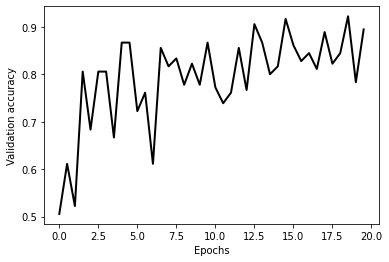

In [73]:
plt.close('all')

proto_val = np.load('/content/gdrive/My Drive/cs330_hw2/proto_prob2.npy')
plt.plot(np.arange(len(proto_val))*0.5, proto_val, linewidth=2, linestyle='solid', color='k')
plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')
#plt.legend()
plt.savefig('/content/gdrive/My Drive/cs330_hw2/prob_2.3.png')

# Prob 3

In [ ]:
# Train MAML
val_acc = run_maml(n_way=5, k_shot=1, inner_update_lr=0.4, num_inner_updates=1, logdir='/content/gdrive/My Drive/cs330_hw2')
val_acc = np.array([v.numpy() for v in val_acc])
np.save('/content/gdrive/My Drive/cs330_hw2/prob3_val_acc.npy', val_acc)

Iteration 10: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.20000
Iteration 20: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.21600
Iteration 30: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.18400
Iteration 40: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.18400
Iteration 50: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.21600
Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.20800
Iteration 60: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20800
Iteration 70: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.24800
Iteration 80: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.21600
Iteration 90: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.23200
Iteration 100: pre-inner-loop train accuracy: 0.1840

In [ ]:
test_K = [4, 6, 8, 10]
for k in test_K:
  print("meta test K={:d}".format(k))
  # Test protonet
  proto_val_acc_k = run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=k, n_meta_test_query=4)
  np.save('/content/gdrive/My Drive/cs330_hw2/prob3_proto_val_acc_test_K={:d}.npy'.format(k), proto_val_acc_k)
  # Test MAML
  maml_test_acc_k = run_maml(n_way=5, k_shot=k, inner_update_lr=0.4, num_inner_updates=1, meta_train=False, meta_test_set=True, meta_train_k_shot=1, 
                             model_file='/content/gdrive/My Drive/cs330_hw2/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False')
  np.save('/content/gdrive/My Drive/cs330_hw2/prob3_maml_test_acc_test_K={:d}.npy'.format(k), maml_test_acc_k)

In [ ]:
plt.close('all')

maml_acc_mean = np.empty(len(test_K))
maml_acc_std = np.empty(len(test_K))
for k in test_K:
  maml_test_acc_k = np.load('/content/gdrive/My Drive/cs330_hw2/prob3_maml_test_acc_test_K={:d}.npy'.format(k))
  maml_acc_mean[k] = np.mean(maml_test_acc_k) 
  maml_acc_std[k] = np.std(maml_test_acc_k)

proto_acc_mean = np.array([])
proto_acc_std = np.array([])
# Errorbar version
plt.errorbar(test_K, maml_acc_mean, yerr=maml_acc_std, color='k', label='ProtoNet')
plt.errorbar(test_K, proto_acc_mean, yerr=proto_acc_std, color='tab:orange', label='MAML')
# Errorband version
plt.plot(test_K, proto_acc_mean, color='k', label='ProtoNet')
plt.fill_between(test_K, proto_acc_mean - proto_acc_std, proto_acc_mean + proto_acc_std, alpha=0.2, facecolor='tab:gray')
plt.plot(test_K, maml_acc_mean, color='k', label='MAML')
plt.fill_between(test_K, maml_acc_mean - maml_acc_std, maml_acc_mean + maml_acc_std, alpha=0.2, facecolor='tab:orange')

plt.ylabel('Meta-test accuracy')
plt.xlabel('Meta-test K')
plt.legend()